In [2]:
import qiskit
print(qiskit.__version__)

1.1.1


# Finding minimum/maximum eigenvalues using VQE

Many problems in Mathematics, Physics and Chemistry require the estimation of the minimum or the maximum eigenvalues of a system. Classically, for very large systems, variational forms have been in use to derive them. Let us say we have been given an operator (matrix) $L$, whose minimum eigenvalue we are interested in. 

We start off with an initial parametrized good guess (ansatz) $\left| \psi (\theta) \right\rangle$. The expectation of this operator with respect to this ansatz $E = \left\langle L \right\rangle = \left\langle \psi (\theta)\right| L \left| \psi (\theta) \right\rangle$ is then calculated. An optimizer is then used to find the optimal parameters that minimizes (maximizes) this expectation value. The variational form ensures that 

$$ \lambda _{min} \leq \left\langle \psi (\theta)\right| L \left| \psi (\theta) \right\rangle.$$

A perfect guess would be when the ansatz is the minimum eigenvector. That would give us $E = \lambda _{min}$, the minimum eigenvalue. 

For implementation in a Quantum computer the operator is expressed as a sum of Pauli operators, $Z, X, Y$ and $I$. Let us say, we want to find the minimum eigenvalue of the matrix $$ A = \left[\begin{array}{cc} 2 & 3 \\ 3 & 6 \\  
\end{array}\right]$$. 

Now $A$ could be written as a sum of Pauli operators as follows.
$$A = -2Z + 4I + 3X$$

The expectation of $A$, $\left\langle A \right\rangle$, can be expressed as 
$$ \left\langle A \right\rangle = -2\left\langle Z \right\rangle + 4 + 3 \left\langle X \right\rangle $$


This problem can be solved using a single qubit system, as our matrix is of size 2×2. We will create our ansatz by applying the 𝑈 gate to a |0⟩. The 𝑈 gate requires 3 parameters. More on 𝑈 gate can be found in the following link.

https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.UGate

Let us first find the eigenvalues of the matrix 𝐴 classically. 

In [3]:
import numpy as np

AA = np.array([[2, 3],[3, 6]])
print(np.linalg.eig(AA)[0])

[0.39444872 7.60555128]


In [4]:
from qiskit import QuantumCircuit 
from qiskit.visualization import plot_histogram

In [5]:
def var_circuit(params):
    var_circ = QuantumCircuit(1)
    var_circ.u(params[0], params[1], params[2],0)
    return var_circ

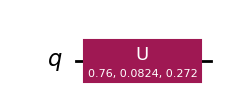

In [6]:
params = np.random.rand(3)
pri_ckt = var_circuit(params)
pri_ckt.draw('mpl')

## Estimating $\left\langle Z \right\rangle$

The result of this measurement can either be $\left| 0 \right\rangle$ or $\left| 1 \right\rangle$. Since both are eigenvectors of $Z$, with eigenvalues $1$ and $-1$, $\left\langle Z \right\rangle$ will be equal to the number of times we have $1$ minus the mumber of times we have $-1$. 
For example, let us say, $\left| \psi \right\rangle = c_1 \left| 0 \right\rangle + c_2 \left| 1 \right\rangle.$ Then,

$$\left\langle \psi \right| Z \left| \psi \right\rangle = c_1 ^2 - c_2 ^2 $$


$c_1^2$ is the probability of occurence of $\left| 0 \right\rangle$ and $c_2^2$ is the probability of occurence of $\left| 1 \right\rangle$. This is calculated as given below.

### We will first do it with a simulator. Then a fake backend.

In [5]:
from qiskit_aer.primitives import Sampler

sampler_sim = Sampler(backend_options={"method": "matrix_product_state", "shots":10000})

{1: 0.1399, 0: 0.8601}


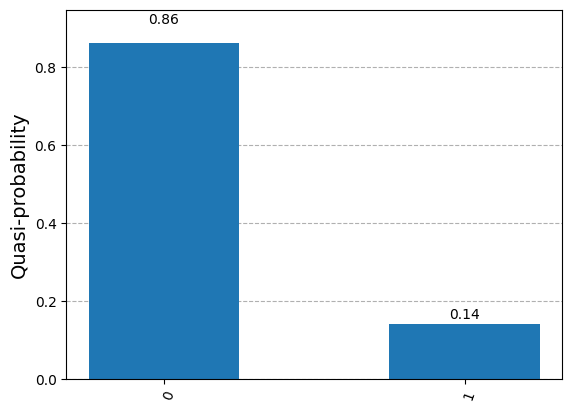

In [8]:
Zmeas = pri_ckt.copy()
Zmeas.measure_all()
Zmeas.draw('mpl')

result = sampler_sim.run(Zmeas).result()
counts = result.quasi_dists[0]
print(counts)
zz = counts[0] - counts[1]
plot_histogram(counts) 

## Estimating $\left\langle X \right\rangle$

In a Quantum computer measurements are always performed in the $Z$ computational basis. $\left\langle X \right\rangle$ can be estimated by first expressing $X$ in the form $HZH$ using the Hadamard gates $H$. That would give us the following.

$$ \left\langle\psi\right| X\left| \psi\right\rangle = \left\langle \psi\right| HZH \left| \psi\right\rangle$$
$$  = \left\langle \psi H \right| Z \left| H\psi\right\rangle$$

This is equivalent to finding $\left\langle Z \right\rangle$ after operating an extra Hadamard gate on the ansatz. This is as given below. 

{1: 0.158, 0: 0.842}


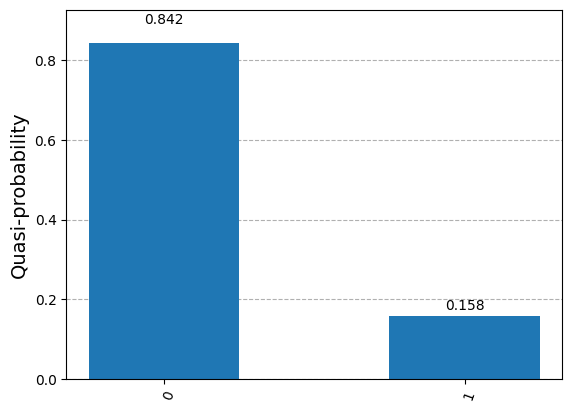

In [9]:
Xmeas = pri_ckt.copy()
Xmeas.h(0)
Xmeas.measure_all()
Xmeas.draw('mpl')
result = sampler_sim.run(Xmeas).result()
counts = result.quasi_dists[0]

print(counts)
xx = counts[0] - counts[1]
plot_histogram(counts) 

## Overall expectation value of the operator

In [10]:
eig_value = -2*zz + 4 + 3*xx
print(eig_value)

4.611599999999999


We started off with a random set of paramaters and reached a value of xx using 100 shots for calculating the expectation. This is not close to the expected lowest eigenvalue of $0.39$. We will have to further optimize the parameters using an optimizer, which will form the classical part of the system. 

### Overall expectation function
Putting all the expectation value evaluations together under function.

In [6]:
def expectation_function(params):
    var_circ = QuantumCircuit(1)
    var_circ.u(params[0], params[1], params[2],0)
        
    #### Z measurement #####
    Zmeas = var_circ.copy()
    Zmeas.measure_all()
    result = sampler_sim.run(Zmeas).result()
    counts = result.quasi_dists[0]
    
    zz = counts[0] - counts[1]

    #### X measurement #####
    Xmeas = var_circ.copy()
    Xmeas.h(0)
    Xmeas.measure_all()
    result = sampler_sim.run(Xmeas).result()
    counts = result.quasi_dists[0]
    
    xx = counts[0] - counts[1]
    
    cost = -2*zz + 3*xx + 4
    print(cost, params)
    return cost

from qiskit_algorithms.optimizers import COBYLA

optimizer = COBYLA(maxiter=100, tol=0.0001, disp = True)
params = np.random.rand(3)
ret = optimizer.minimize(expectation_function, params)
print(ret)

3.7960000000000003 [0.68799047 0.78678961 0.17688487]
6.348800000000001 [1.68799047 0.78678961 0.17688487]
2.0194 [0.68799047 1.78678961 0.17688487]
2.0094000000000003 [0.68799047 1.78678961 1.17688487]
2.2889999999999997 [-0.13279907  2.35801129  1.18010013]
1.5606 [1.0199221  2.16071068 1.17898957]
1.3496000000000001 [1.41732032 2.46409948 1.18445669]
2.4446 [1.86127497 2.38247736 1.39949645]
1.0907999999999998 [1.33431473 2.56901985 1.39564804]
0.46499999999999986 [1.09417426 2.99141757 1.27769586]
0.4878 [0.92920143 3.44459691 1.40965212]
0.4925999999999999 [1.20240672 3.08712941 1.07367386]
0.39180000000000037 [0.88169365 2.94636426 1.15391303]
0.5211999999999999 [0.77161756 2.894512   1.12528439]
0.4695999999999998 [0.91096743 2.90331211 1.11933256]
0.4032 [0.88391099 3.05487335 1.09189803]
0.4321999999999999 [0.89502878 2.97368869 1.20851889]
0.4788000000000001 [0.88168975 2.97214971 1.13625877]
0.47099999999999964 [0.85538724 2.93213797 1.1629766 ]
0.4742000000000002 [0.8943584

## We will use a fake backend now

In [7]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke, FakeManilaV2, FakeMumbaiV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# backend = FakeManilaV2()
backend = FakeMumbaiV2()
sampler_fake = Sampler(backend)

In [14]:
def expectation_function(params):
    pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
    
    var_circ = QuantumCircuit(1)
    var_circ.u(params[0], params[1], params[2],0)
    shots = 10000    
    #### Z measurement #####
    Zmeas = var_circ.copy()
    Zmeas.measure_all()
    
    Zmeas_tr = pm.run(Zmeas)
    result = sampler_fake.run([Zmeas_tr], shots = shots).result()
    counts = result[0].data.meas.get_counts()
    total_counts = counts['0'] + counts['1']
    zz = (counts['0'] - counts['1'])/total_counts
    
    #### X measurement #####
    Xmeas = var_circ.copy()
    Xmeas.h(0)
    Xmeas.measure_all()
    
    Xmeas_tr = pm.run(Xmeas)
    result = sampler_fake.run([Xmeas_tr], shots = shots).result()
    counts = result[0].data.meas.get_counts()
    total_counts = counts['0'] + counts['1']
    xx = (counts['0'] - counts['1'])/total_counts
    
    cost = -2*zz + 3*xx + 4
    # print(cost, params)
    return cost

from qiskit_algorithms.optimizers import COBYLA
optimizer = COBYLA(maxiter=100)
params = np.random.rand(3)
ret = optimizer.minimize(expectation_function, params)
print(ret)

{   'fun': 0.5947999999999998,
    'jac': None,
    'nfev': 42,
    'nit': None,
    'njev': None,
    'x': array([0.93894934, 3.01299994, 0.56466211])}


We have reached $0.4$ which is almost equal to the value we wanted. To get the maximum eigenvalue, we will have to just negate the cost function. 

This methodology can be used to find the minimum eigenvalues of much bigger systems. We will try to find the smallest eigenvalue of the $4\times4$ operator given by 

$$ L = 2XX $$

Here a $XX = X\otimes X$. 

Let us first find out the eigenvalues of the matrix $L$. 

In [16]:
X = np.array([[0, 1],[1, 0]])
XX = np.kron(X,X)
L = 2*XX
print(np.linalg.eig(L)[0])

[ 2. -2.  2. -2.]


Let us first create our ansatz. For creating the ansatz we will use a combination of $R_y$, $R_z$ and $CNOT$ (`CX`) gates as shown below. However, unlike in our previous example, these variational forms have to repeated several times for better results. 

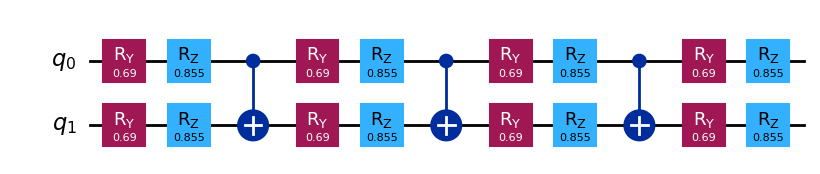

In [15]:
def var_form(params, depth):
    var_circ = QuantumCircuit(2)
    var_circ.ry(params[0], 0)
    var_circ.rz(params[1], 0)
    var_circ.ry(params[0], 1)
    var_circ.rz(params[1], 1)
        
    for jj in range(depth):
        var_circ.cx(0, 1)
        var_circ.ry(params[0], 0)
        var_circ.rz(params[1], 0)
        var_circ.ry(params[0], 1)
        var_circ.rz(params[1], 1)
    
    return var_circ 

params = np.random.rand(2)
depth = 3
ckt = var_form(params, depth)
ckt.draw('mpl')

We write down our expectation function now. Our operator has two $X$ Pauli matrices. We can convert them to the Z form by operating $H$ gates on both the qubits. For finding the expectation of $\left\langle ZZ \right\rangle$, we must remember the following.
\begin{equation}
\begin{aligned}
ZZ\left| 00 \right\rangle &= \left| 00 \right\rangle \\
ZZ\left| 01 \right\rangle &= -\left| 01 \right\rangle \\
ZZ\left| 10 \right\rangle &= -\left| 10 \right\rangle \\
ZZ\left| 11 \right\rangle &= \left| 11 \right\rangle 
\end{aligned}
\end{equation}

Thus 
$$\left\langle ZZ \right\rangle = \textrm{\#('00') + \#('11') - \#('01') - \#('10')}$$

In [17]:
### Simulator
def expectation_function2(params, num_shots = 10000):
    var_circ = var_form(params, 2)
    
    #### XX measurement #####
    Xmeas = var_circ.copy()
    Xmeas.h(0)
    Xmeas.h(1)
    Xmeas.measure_all()
    result = sampler_sim.run(Xmeas).result()
    counts = result.quasi_dists[0]
    
    list_bin = [0,1,2,3]
    for jj in list_bin:
        if jj not in counts:
            counts[jj] = 0

    xx = counts[0] + counts[3] - counts[2] - counts[1] 
    
    cost = 2*xx
    return cost

optimizer = COBYLA(maxiter=100, tol=0.0001)
params = np.random.rand(2)
ret = optimizer.minimize(expectation_function2, params)
print(ret)

{   'fun': -1.9964,
    'jac': None,
    'nfev': 30,
    'nit': None,
    'njev': None,
    'x': array([1.52717423, 1.59091775])}


In [18]:
### Fake backend
def expectation_function2(params, num_shots = 10000):
    pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
    var_circ = var_form(params, 2)
    num_shots = 10000    
    
    #### XX measurement #####
    Xmeas = var_circ.copy()
    Xmeas.h(0)
    Xmeas.h(1)
    Xmeas.measure_all()
    Xmeas_tr = pm.run(Xmeas)
    result = sampler_fake.run([Xmeas_tr], shots = num_shots).result()
    counts = result[0].data.meas.get_counts()
    
    list_bin = ['00','01','10','11']
    for jj in list_bin:
        if jj not in counts:
            counts[jj] = 0
    
    total_counts = counts['00'] + counts['11'] + counts['10'] + counts['01']
    xx = counts['00'] + counts['11'] - counts['10'] - counts['01'] 
    xx = xx / total_counts
    
    cost = 2*xx
    return cost

optimizer = COBYLA(maxiter=100)
params = np.random.rand(2)
ret = optimizer.minimize(expectation_function2, params)
print(ret)

{   'fun': -1.6616,
    'jac': None,
    'nfev': 31,
    'nit': None,
    'njev': None,
    'x': array([1.58299879, 0.0855773 ])}


We have been able to get the minimum eigenvalue correctly here as well. 

As an exercise try finding the minimum and maximum eigenvalues of the following operator.

$$ L = 2XX + 6IZ $$

Use a variational form comprising of $R_y$, $R_z$ and `CX` gates.

### Solution to the above problem

In [13]:
### Eigenvalues of L #####
X = np.array([[0, 1],[1, 0]])
Z = np.array([[1, 0],[0, -1]])
I = np.array([[1, 0],[0, 1]])

L = 2*np.kron(X,X) + 6*np.kron(I,Z)
print(np.linalg.eig(L)[0])

[ 6.32455532 -6.32455532  6.32455532 -6.32455532]


In [14]:
def var_form_ryrz(params, depth):
    var_circ = QuantumCircuit(2)
    var_circ.ry(params[0], 0)
    var_circ.rz(params[1], 0)
    var_circ.ry(params[2], 1)
    var_circ.rz(params[3], 1)    
           
    for jj in range(depth):
        var_circ.cx(0, 1)
        var_circ.ry(params[0], 0)
        var_circ.rz(params[1], 0)
        var_circ.ry(params[2], 1)
        var_circ.rz(params[3], 1) 
            
    return var_circ  

In [20]:
## Simulator
def expectation_function3(params, num_shots = 10000):
    var_circ = var_form_ryrz(params, 2)
    
    #### XX measurement #####
    Xmeas = var_circ.copy()
    Xmeas.h(0)
    Xmeas.h(1)
    Xmeas.measure_all()
    result = sampler_sim.run(Xmeas).result()
    counts = result.quasi_dists[0]
    
    list_bin = [0,1,2,3]
    for jj in list_bin:
        if jj not in counts:
            counts[jj] = 0

            
    total_counts = counts[0] + counts[1] + counts[2] + counts[3]
    xx = counts[0] + counts[3] - counts[2] - counts[1] 
    
    #### IZ measurement #####
    IZmeas = var_circ.copy()
    IZmeas.measure_all()
    result = sampler_sim.run(IZmeas).result()
    counts = result.quasi_dists[0]
    
    for jj in list_bin:
        if jj not in counts:
            counts[jj] = 0
            
    total_counts = counts[0] + counts[1] + counts[2] + counts[3]
    iz = counts[0] - counts[3] + counts[2] - counts[1] 
    
    cost = 2*xx + 6*iz
    return cost

optimizer = COBYLA(maxiter=100, tol=0.0001)
params = np.random.rand(4)
ret = optimizer.minimize(expectation_function3, params)
print(ret)

{   'fun': -6.158799999999999,
    'jac': None,
    'nfev': 56,
    'nit': None,
    'njev': None,
    'x': array([ 1.30394481, -0.0602682 ,  0.94716791, -0.03718907])}


### Another problem

$$ L = 2XI + 6IY $$

Remember $Y = R_z(\pi/2)HZHR_z'(\pi/2)$

In [8]:
### Eigenvalues of L #####
X = np.array([[0, 1],[1, 0]])
Y = 1j*np.array([[0, -1],[1, 0]])
I = np.array([[1, 0],[0, 1]])

L1 = 2*np.kron(X,I) + 6*np.kron(I,Y)
print(np.real(np.linalg.eig(L1)[0]))

L2 = 2*np.kron(I,X) + 6*np.kron(Y,I)
print(np.real(np.linalg.eig(L2)[0]))

[ 8.  4. -8. -4.]
[ 8.  4. -8. -4.]


In [9]:
def var_form_ryrz(params, depth):
    var_circ = QuantumCircuit(2,3)
    var_circ.ry(params[0], 0)
    var_circ.rz(params[1], 0)
    var_circ.ry(params[2], 1)
    var_circ.rz(params[3], 1)    
           
    for jj in range(depth):
        var_circ.cx(0, 1)
        var_circ.ry(params[4], 0)
        var_circ.rz(params[5], 0)
        var_circ.ry(params[6], 1)
        var_circ.rz(params[7], 1) 
            
    return var_circ  

In [10]:
from qiskit.result import marginal_counts
def expectation_function4(params, num_shots = 10000):
    depth = 1
    var_circ = var_form_ryrz(params, depth)

    #### XI measurement #####
    XI_IY_meas = var_circ.copy()
    XI_IY_meas.h(1)
    XI_IY_meas.measure([1],[1])
    XI_IY_meas.barrier([0,1])

    #### IY measurement #####
    XI_IY_meas.rz(-np.pi/2,0)
    XI_IY_meas.h(0)  
    XI_IY_meas.measure([0],[0])

    result = sampler_sim.run(XI_IY_meas).result()
    bin_num: dict[str, int] = {}
    for key, val in result.quasi_dists[0].items():
        bin_num[str(bin(key)[2:].zfill(2))] = int(val*num_shots)

    counts_iy = marginal_counts(bin_num, indices=[0])
    counts_xi = marginal_counts(bin_num, indices=[1])

    list_bin = ['0','1']
    for jj in list_bin:
        if jj not in counts_xi:
            counts_xi[jj] = 0
        if jj not in counts_iy:
            counts_iy[jj] = 0

    total_counts = counts_xi['0'] + counts_xi['1']
    xi = counts_xi['0'] - counts_xi['1']
    xi = xi / total_counts

    total_counts = counts_iy['0'] + counts_iy['1']
    iy = counts_iy['0'] - counts_iy['1']
    iy = iy / total_counts

    cost = 2*xi + 6*iy
    return cost

In [11]:
optimizer = COBYLA(maxiter=100, tol=0.0001)
params = np.random.rand(8)
ret = optimizer.minimize(expectation_function4, params)
print(ret)
exp = expectation_function4(ret.x)
print(exp)

{   'fun': -8.0,
    'jac': None,
    'nfev': 100,
    'nit': None,
    'njev': None,
    'x': array([ 3.12613495,  1.61737179, -0.83756059,  2.3057307 ,  1.56719836,
        1.56843961,  2.23068448,  0.58270338])}
-8.0


## Using Estimator primitive

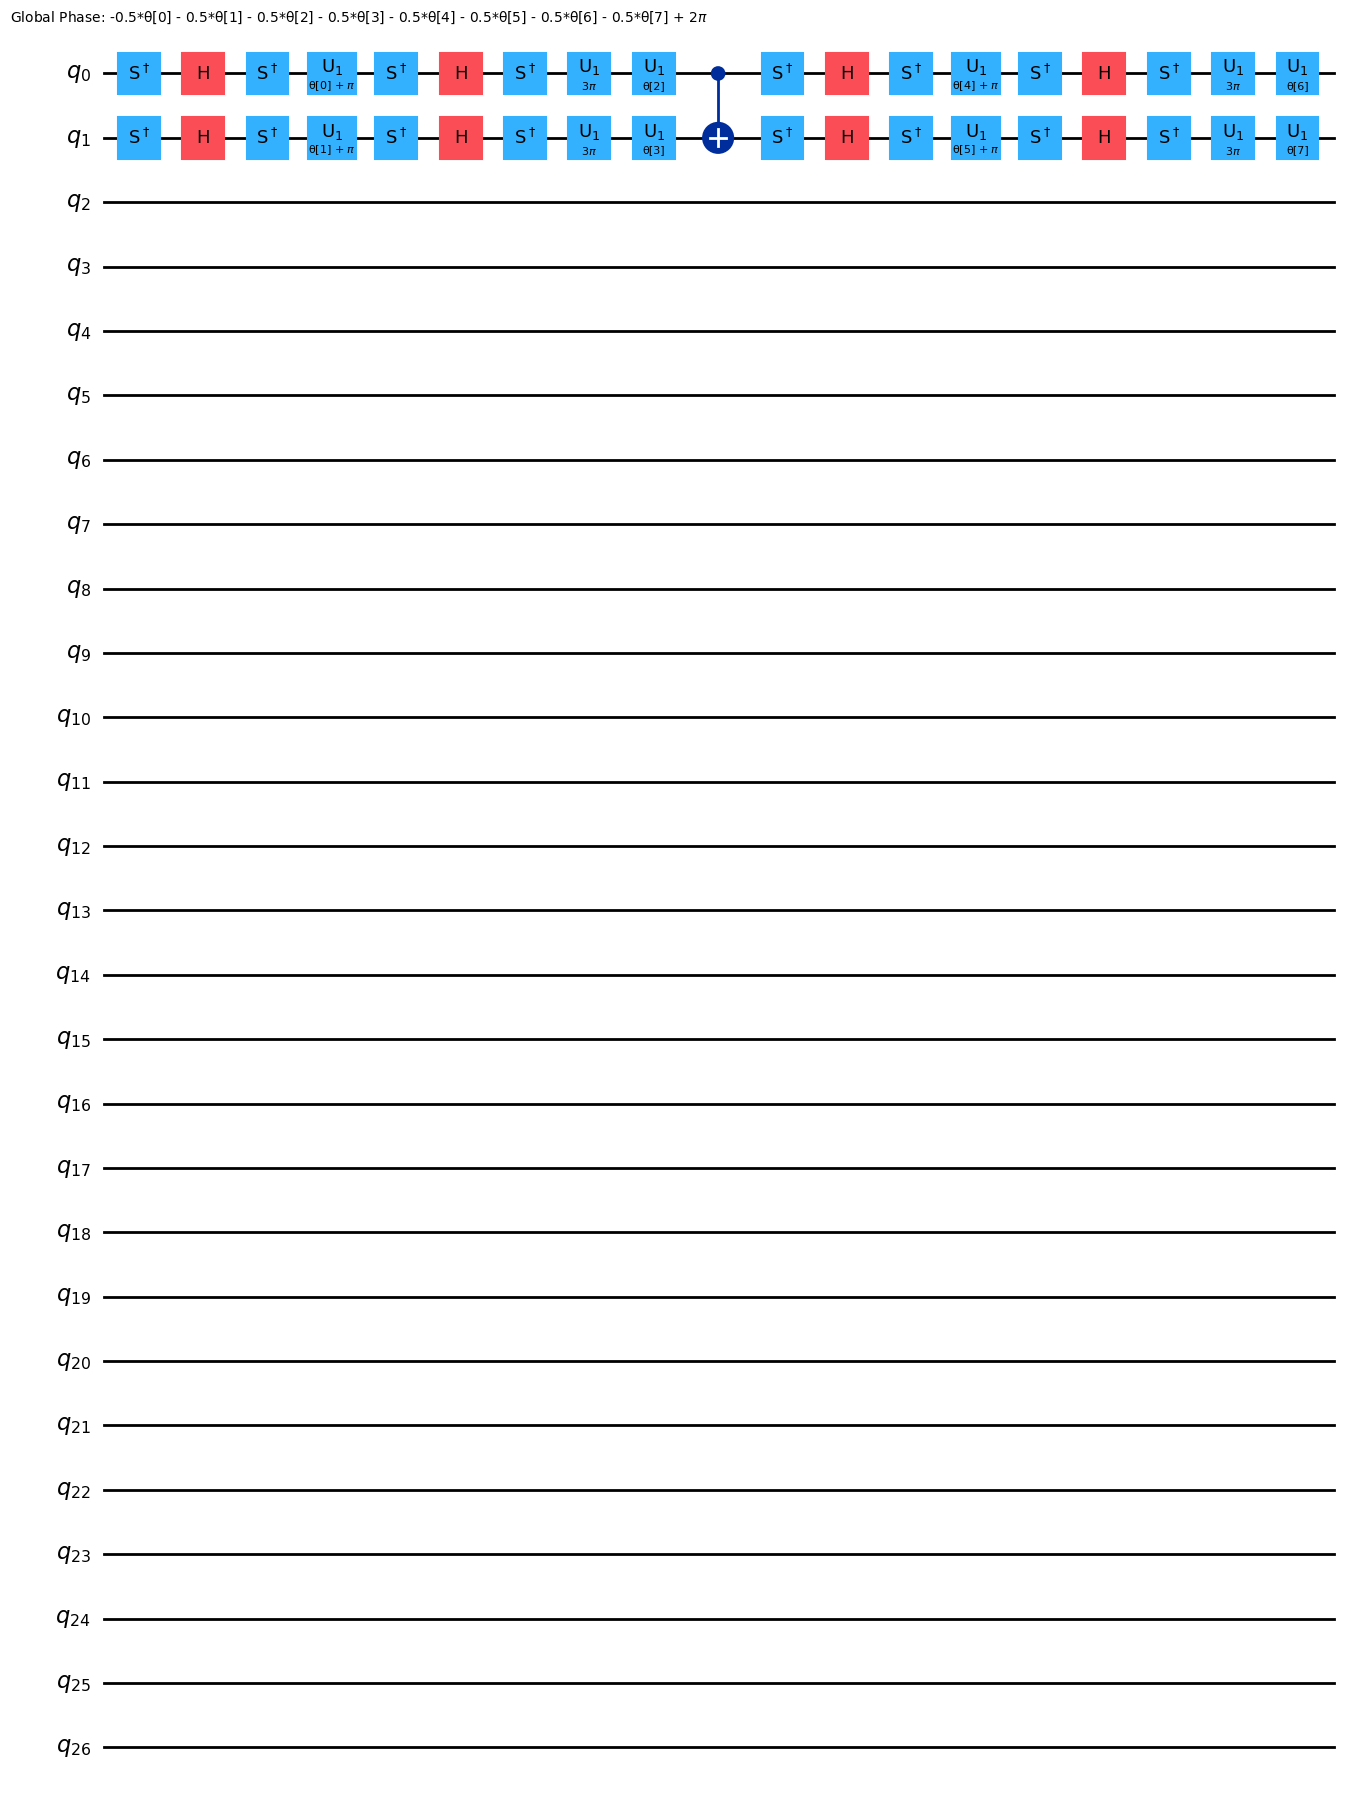

In [12]:
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import RealAmplitudes, EfficientSU2
from qiskit.circuit.library import TwoLocal

observable = SparsePauliOp.from_list([("XI", 2), ("IY", 6)])
var_form = EfficientSU2(num_qubits= 2, reps=1)
# var_form = TwoLocal(
#     2,
#     rotation_blocks=["rz", "ry"],
#     entanglement_blocks="cx",
#     entanglement="linear",
#     reps=1,
# )
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
var_circ = QuantumCircuit(2)
ansatz = var_circ.compose(var_form)
ansatz_tr = pm.run(ansatz)
observable_tr = observable.apply_layout(ansatz_tr.layout)
ansatz_tr.decompose().draw('mpl')
# print(observable_tr)

In [13]:
from scipy.optimize import minimize
from qiskit.primitives import StatevectorEstimator

estimator = StatevectorEstimator()
# estimator = Estimator(backend)
def cost_func_vqe(parameters, ansatz, hamiltonian, estimator):

    estimator_job = estimator.run([(ansatz, hamiltonian, [parameters])])
    estimator_result = estimator_job.result()[0]

    cost = estimator_result.data.evs[0]
    return cost

x0 = np.random.rand(8)
result = minimize(cost_func_vqe, x0, args=(ansatz, observable, estimator), method="COBYLA")
print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -7.9999999416466565
       x: [ 1.482e+00  1.571e+00  1.383e+00  3.142e+00 -4.461e-01
           -1.496e-04  2.077e-01 -1.324e-04]
    nfev: 150
   maxcv: 0.0
